In [ ]:
from sys import int_info
from time import sleep

import numpy as np
import glob
import matplotlib.pyplot as plt

import os
import cv2
import pickle
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

import warnings

numClasses = 10
batch_size = 256
learning_rate = 0.01
op = 'SGD'
epochs =80

optimizers = {'SGD':torch.optim.SGD, 'Adam':torch.optim.Adam, 'RMSprop':torch.optim.RMSprop}


# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor()])
trainDataset = torchvision.datasets.CIFAR10(root = './', train = True, download = True, transform = transform)
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, shuffle = True, num_workers = 0)
testDataset = torchvision.datasets.CIFAR10(root = './', train = False, download = True, transform = transform)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size = batch_size, shuffle = True, num_workers = 0)


class VGG16(nn.Module):
    def __init__(self, numClasses=10):
        super(VGG16, self).__init__()
        self.vgg16 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096), nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, numClasses)
        )
        
    def forward(self, x):
        x = self.vgg16(x)
        return x



model = VGG16(numClasses=numClasses)

use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

optimizer = optimizers[op](model.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(3, 32, 32))

from tqdm import tqdm
from IPython.display import clear_output

loss_epochs = []
train_acc_epochs = []
test_acc_epochs = []

for epoch in range(epochs):
    loss_batch = 0.0
    acc_batch = 0.0
    model.train()
    for i, data in tqdm(enumerate(trainLoader, 1)):
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        
        
        acc_batch += (predicted == labels).sum().item()
        loss_batch += loss.item()
        
        #print('[%d, %5d] loss: %.3f' % (epoch, i * batch_size, loss))
        #clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #break
        
        
    loss_batch /= i
    acc_batch /= (i * batch_size)

    
    print("[%2d, %5d] Train Loss: %.3f" % (epoch + 1, i * batch_size, loss_batch))
    print("[%2d, %5d] Train Accuracy: %.3f" % (epoch + 1, i * batch_size, acc_batch))

    loss_epochs.append(loss_batch)
    train_acc_epochs.append(acc_batch)

    model.eval()
    loss_batch = 0.0
    acc_batch = 0.0

    for i, data in enumerate(testLoader, 1):
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs = Variable(inputs, volatile=True)
        labels = Variable(labels, volatile=True)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        num_correct = (predicted == labels).sum().item()

        loss_batch += loss.item() 
        acc_batch += num_correct

    loss_batch /= i
    acc_batch /= (i * batch_size)
    test_acc_epochs.append(acc_batch)

    print("[%2d, %5d] Test Loss: %.3f" % (epoch + 1, i * batch_size, loss_batch))
    print("[%2d, %5d] Test Accuracy: %.3f" % (epoch + 1, i * batch_size, acc_batch))

print(loss_epochs)
print(train_acc_epochs)
print(test_acc_epochs)
torch.save(model, './drive/MyDrive/成大/vgg16_10280250.pkl',_use_new_zipfile_serialization=False)



Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13       

196it [01:09,  2.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[ 1, 50176] Train Loss: 1.407
[ 1, 50176] Train Accuracy: 0.475
[ 1, 10240] Test Loss: 1.106
[ 1, 10240] Test Accuracy: 0.591


196it [01:08,  2.85it/s]


[ 2, 50176] Train Loss: 0.833
[ 2, 50176] Train Accuracy: 0.706
[ 2, 10240] Test Loss: 0.919
[ 2, 10240] Test Accuracy: 0.671


196it [01:08,  2.85it/s]


[ 3, 50176] Train Loss: 0.608
[ 3, 50176] Train Accuracy: 0.787
[ 3, 10240] Test Loss: 0.816
[ 3, 10240] Test Accuracy: 0.713


196it [01:08,  2.85it/s]


[ 4, 50176] Train Loss: 0.467
[ 4, 50176] Train Accuracy: 0.837
[ 4, 10240] Test Loss: 0.661
[ 4, 10240] Test Accuracy: 0.762


196it [01:08,  2.85it/s]


[ 5, 50176] Train Loss: 0.366
[ 5, 50176] Train Accuracy: 0.874
[ 5, 10240] Test Loss: 0.661
[ 5, 10240] Test Accuracy: 0.765


196it [01:08,  2.85it/s]


[ 6, 50176] Train Loss: 0.281
[ 6, 50176] Train Accuracy: 0.902
[ 6, 10240] Test Loss: 0.667
[ 6, 10240] Test Accuracy: 0.780


196it [01:08,  2.85it/s]


[ 7, 50176] Train Loss: 0.215
[ 7, 50176] Train Accuracy: 0.923
[ 7, 10240] Test Loss: 0.698
[ 7, 10240] Test Accuracy: 0.772


196it [01:08,  2.85it/s]


[ 8, 50176] Train Loss: 0.180
[ 8, 50176] Train Accuracy: 0.935
[ 8, 10240] Test Loss: 0.647
[ 8, 10240] Test Accuracy: 0.794


196it [01:08,  2.85it/s]


[ 9, 50176] Train Loss: 0.124
[ 9, 50176] Train Accuracy: 0.955
[ 9, 10240] Test Loss: 0.724
[ 9, 10240] Test Accuracy: 0.789


196it [01:08,  2.85it/s]


[10, 50176] Train Loss: 0.110
[10, 50176] Train Accuracy: 0.960
[10, 10240] Test Loss: 0.966
[10, 10240] Test Accuracy: 0.755


196it [01:08,  2.85it/s]


[11, 50176] Train Loss: 0.088
[11, 50176] Train Accuracy: 0.967
[11, 10240] Test Loss: 0.752
[11, 10240] Test Accuracy: 0.792


196it [01:08,  2.85it/s]


[12, 50176] Train Loss: 0.071
[12, 50176] Train Accuracy: 0.973
[12, 10240] Test Loss: 0.874
[12, 10240] Test Accuracy: 0.784


196it [01:08,  2.85it/s]


[13, 50176] Train Loss: 0.058
[13, 50176] Train Accuracy: 0.977
[13, 10240] Test Loss: 0.775
[13, 10240] Test Accuracy: 0.803


196it [01:08,  2.85it/s]


[14, 50176] Train Loss: 0.049
[14, 50176] Train Accuracy: 0.981
[14, 10240] Test Loss: 0.791
[14, 10240] Test Accuracy: 0.809


196it [01:08,  2.85it/s]


[15, 50176] Train Loss: 0.042
[15, 50176] Train Accuracy: 0.982
[15, 10240] Test Loss: 0.983
[15, 10240] Test Accuracy: 0.786


196it [01:08,  2.85it/s]


[16, 50176] Train Loss: 0.042
[16, 50176] Train Accuracy: 0.982
[16, 10240] Test Loss: 0.882
[16, 10240] Test Accuracy: 0.796


196it [01:08,  2.85it/s]


[17, 50176] Train Loss: 0.035
[17, 50176] Train Accuracy: 0.985
[17, 10240] Test Loss: 0.811
[17, 10240] Test Accuracy: 0.807


196it [01:08,  2.85it/s]


[18, 50176] Train Loss: 0.029
[18, 50176] Train Accuracy: 0.987
[18, 10240] Test Loss: 0.886
[18, 10240] Test Accuracy: 0.806


196it [01:08,  2.85it/s]


[19, 50176] Train Loss: 0.028
[19, 50176] Train Accuracy: 0.987
[19, 10240] Test Loss: 0.873
[19, 10240] Test Accuracy: 0.806


196it [01:08,  2.85it/s]


[20, 50176] Train Loss: 0.028
[20, 50176] Train Accuracy: 0.987
[20, 10240] Test Loss: 0.776
[20, 10240] Test Accuracy: 0.811


196it [01:08,  2.85it/s]


[21, 50176] Train Loss: 0.019
[21, 50176] Train Accuracy: 0.990
[21, 10240] Test Loss: 0.791
[21, 10240] Test Accuracy: 0.823


196it [01:08,  2.85it/s]


[22, 50176] Train Loss: 0.015
[22, 50176] Train Accuracy: 0.992
[22, 10240] Test Loss: 0.836
[22, 10240] Test Accuracy: 0.818


196it [01:08,  2.85it/s]


[23, 50176] Train Loss: 0.021
[23, 50176] Train Accuracy: 0.989
[23, 10240] Test Loss: 0.855
[23, 10240] Test Accuracy: 0.817


196it [01:08,  2.85it/s]


[24, 50176] Train Loss: 0.017
[24, 50176] Train Accuracy: 0.991
[24, 10240] Test Loss: 0.913
[24, 10240] Test Accuracy: 0.812


196it [01:08,  2.85it/s]


[25, 50176] Train Loss: 0.018
[25, 50176] Train Accuracy: 0.991
[25, 10240] Test Loss: 0.890
[25, 10240] Test Accuracy: 0.814


196it [01:08,  2.85it/s]


[26, 50176] Train Loss: 0.017
[26, 50176] Train Accuracy: 0.991
[26, 10240] Test Loss: 0.899
[26, 10240] Test Accuracy: 0.818


196it [01:08,  2.85it/s]


[27, 50176] Train Loss: 0.015
[27, 50176] Train Accuracy: 0.992
[27, 10240] Test Loss: 0.922
[27, 10240] Test Accuracy: 0.813


196it [01:08,  2.85it/s]


[28, 50176] Train Loss: 0.015
[28, 50176] Train Accuracy: 0.992
[28, 10240] Test Loss: 0.953
[28, 10240] Test Accuracy: 0.812


196it [01:08,  2.85it/s]


[29, 50176] Train Loss: 0.015
[29, 50176] Train Accuracy: 0.991
[29, 10240] Test Loss: 0.926
[29, 10240] Test Accuracy: 0.818


196it [01:08,  2.85it/s]


[30, 50176] Train Loss: 0.009
[30, 50176] Train Accuracy: 0.994
[30, 10240] Test Loss: 0.857
[30, 10240] Test Accuracy: 0.820


196it [01:08,  2.85it/s]


[31, 50176] Train Loss: 0.005
[31, 50176] Train Accuracy: 0.995
[31, 10240] Test Loss: 0.854
[31, 10240] Test Accuracy: 0.830


196it [01:08,  2.85it/s]


[32, 50176] Train Loss: 0.007
[32, 50176] Train Accuracy: 0.994
[32, 10240] Test Loss: 1.019
[32, 10240] Test Accuracy: 0.805


196it [01:08,  2.85it/s]


[33, 50176] Train Loss: 0.010
[33, 50176] Train Accuracy: 0.993
[33, 10240] Test Loss: 0.896
[33, 10240] Test Accuracy: 0.824


196it [01:08,  2.85it/s]


[34, 50176] Train Loss: 0.018
[34, 50176] Train Accuracy: 0.991
[34, 10240] Test Loss: 0.923
[34, 10240] Test Accuracy: 0.819


196it [01:08,  2.85it/s]


[35, 50176] Train Loss: 0.008
[35, 50176] Train Accuracy: 0.994
[35, 10240] Test Loss: 0.889
[35, 10240] Test Accuracy: 0.821


196it [01:08,  2.85it/s]


[36, 50176] Train Loss: 0.006
[36, 50176] Train Accuracy: 0.994
[36, 10240] Test Loss: 0.960
[36, 10240] Test Accuracy: 0.822


196it [01:08,  2.85it/s]


[37, 50176] Train Loss: 0.012
[37, 50176] Train Accuracy: 0.993
[37, 10240] Test Loss: 0.862
[37, 10240] Test Accuracy: 0.822


196it [01:08,  2.85it/s]


[38, 50176] Train Loss: 0.007
[38, 50176] Train Accuracy: 0.995
[38, 10240] Test Loss: 0.882
[38, 10240] Test Accuracy: 0.825


196it [01:08,  2.85it/s]


[39, 50176] Train Loss: 0.004
[39, 50176] Train Accuracy: 0.995
[39, 10240] Test Loss: 0.927
[39, 10240] Test Accuracy: 0.828


196it [01:08,  2.85it/s]


[40, 50176] Train Loss: 0.004
[40, 50176] Train Accuracy: 0.995
[40, 10240] Test Loss: 0.894
[40, 10240] Test Accuracy: 0.832


196it [01:08,  2.85it/s]


[41, 50176] Train Loss: 0.004
[41, 50176] Train Accuracy: 0.995
[41, 10240] Test Loss: 0.940
[41, 10240] Test Accuracy: 0.826


196it [01:08,  2.85it/s]


[42, 50176] Train Loss: 0.010
[42, 50176] Train Accuracy: 0.993
[42, 10240] Test Loss: 0.942
[42, 10240] Test Accuracy: 0.821


196it [01:08,  2.85it/s]


[43, 50176] Train Loss: 0.011
[43, 50176] Train Accuracy: 0.993
[43, 10240] Test Loss: 0.888
[43, 10240] Test Accuracy: 0.823


196it [01:08,  2.85it/s]


[44, 50176] Train Loss: 0.006
[44, 50176] Train Accuracy: 0.994
[44, 10240] Test Loss: 1.016
[44, 10240] Test Accuracy: 0.817


196it [01:08,  2.85it/s]


[45, 50176] Train Loss: 0.007
[45, 50176] Train Accuracy: 0.994
[45, 10240] Test Loss: 0.899
[45, 10240] Test Accuracy: 0.829


196it [01:08,  2.85it/s]


[46, 50176] Train Loss: 0.005
[46, 50176] Train Accuracy: 0.995
[46, 10240] Test Loss: 0.885
[46, 10240] Test Accuracy: 0.834


196it [01:08,  2.85it/s]


[47, 50176] Train Loss: 0.002
[47, 50176] Train Accuracy: 0.996
[47, 10240] Test Loss: 0.868
[47, 10240] Test Accuracy: 0.833


196it [01:08,  2.85it/s]


[48, 50176] Train Loss: 0.002
[48, 50176] Train Accuracy: 0.996
[48, 10240] Test Loss: 0.884
[48, 10240] Test Accuracy: 0.833


196it [01:08,  2.85it/s]


[49, 50176] Train Loss: 0.006
[49, 50176] Train Accuracy: 0.994
[49, 10240] Test Loss: 1.134
[49, 10240] Test Accuracy: 0.809


196it [01:08,  2.85it/s]


[50, 50176] Train Loss: 0.011
[50, 50176] Train Accuracy: 0.993
[50, 10240] Test Loss: 0.885
[50, 10240] Test Accuracy: 0.829


196it [01:08,  2.86it/s]


[51, 50176] Train Loss: 0.005
[51, 50176] Train Accuracy: 0.995
[51, 10240] Test Loss: 0.861
[51, 10240] Test Accuracy: 0.831


196it [01:08,  2.86it/s]


[52, 50176] Train Loss: 0.005
[52, 50176] Train Accuracy: 0.995
[52, 10240] Test Loss: 0.881
[52, 10240] Test Accuracy: 0.828


196it [01:08,  2.86it/s]


[53, 50176] Train Loss: 0.002
[53, 50176] Train Accuracy: 0.996
[53, 10240] Test Loss: 0.901
[53, 10240] Test Accuracy: 0.833


196it [01:08,  2.86it/s]


[54, 50176] Train Loss: 0.001
[54, 50176] Train Accuracy: 0.996
[54, 10240] Test Loss: 0.921
[54, 10240] Test Accuracy: 0.833


196it [01:08,  2.86it/s]


[55, 50176] Train Loss: 0.001
[55, 50176] Train Accuracy: 0.996
[55, 10240] Test Loss: 0.880
[55, 10240] Test Accuracy: 0.840


196it [01:08,  2.86it/s]


[56, 50176] Train Loss: 0.000
[56, 50176] Train Accuracy: 0.996
[56, 10240] Test Loss: 0.873
[56, 10240] Test Accuracy: 0.840


196it [01:08,  2.86it/s]


[57, 50176] Train Loss: 0.000
[57, 50176] Train Accuracy: 0.996
[57, 10240] Test Loss: 0.899
[57, 10240] Test Accuracy: 0.841


196it [01:08,  2.86it/s]


[58, 50176] Train Loss: 0.000
[58, 50176] Train Accuracy: 0.996
[58, 10240] Test Loss: 0.857
[58, 10240] Test Accuracy: 0.842


196it [01:08,  2.86it/s]


[59, 50176] Train Loss: 0.000
[59, 50176] Train Accuracy: 0.996
[59, 10240] Test Loss: 0.885
[59, 10240] Test Accuracy: 0.843


196it [01:08,  2.86it/s]


[60, 50176] Train Loss: 0.000
[60, 50176] Train Accuracy: 0.996
[60, 10240] Test Loss: 0.915
[60, 10240] Test Accuracy: 0.844


196it [01:08,  2.85it/s]


[61, 50176] Train Loss: 0.000
[61, 50176] Train Accuracy: 0.996
[61, 10240] Test Loss: 0.910
[61, 10240] Test Accuracy: 0.844


196it [01:09,  2.84it/s]


[62, 50176] Train Loss: 0.000
[62, 50176] Train Accuracy: 0.996
[62, 10240] Test Loss: 0.873
[62, 10240] Test Accuracy: 0.845


196it [01:09,  2.84it/s]


[63, 50176] Train Loss: 0.000
[63, 50176] Train Accuracy: 0.996
[63, 10240] Test Loss: 0.867
[63, 10240] Test Accuracy: 0.846


196it [01:08,  2.84it/s]


[64, 50176] Train Loss: 0.000
[64, 50176] Train Accuracy: 0.996
[64, 10240] Test Loss: 0.873
[64, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[65, 50176] Train Loss: 0.000
[65, 50176] Train Accuracy: 0.996
[65, 10240] Test Loss: 0.888
[65, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[66, 50176] Train Loss: 0.000
[66, 50176] Train Accuracy: 0.996
[66, 10240] Test Loss: 0.878
[66, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[67, 50176] Train Loss: 0.000
[67, 50176] Train Accuracy: 0.996
[67, 10240] Test Loss: 0.887
[67, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[68, 50176] Train Loss: 0.000
[68, 50176] Train Accuracy: 0.996
[68, 10240] Test Loss: 0.897
[68, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[69, 50176] Train Loss: 0.000
[69, 50176] Train Accuracy: 0.996
[69, 10240] Test Loss: 0.914
[69, 10240] Test Accuracy: 0.845


196it [01:09,  2.83it/s]


[70, 50176] Train Loss: 0.000
[70, 50176] Train Accuracy: 0.996
[70, 10240] Test Loss: 0.899
[70, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[71, 50176] Train Loss: 0.000
[71, 50176] Train Accuracy: 0.996
[71, 10240] Test Loss: 0.892
[71, 10240] Test Accuracy: 0.844


196it [01:08,  2.85it/s]


[72, 50176] Train Loss: 0.000
[72, 50176] Train Accuracy: 0.996
[72, 10240] Test Loss: 0.928
[72, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[73, 50176] Train Loss: 0.000
[73, 50176] Train Accuracy: 0.996
[73, 10240] Test Loss: 0.900
[73, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[74, 50176] Train Loss: 0.000
[74, 50176] Train Accuracy: 0.996
[74, 10240] Test Loss: 0.884
[74, 10240] Test Accuracy: 0.846


196it [01:08,  2.84it/s]


[75, 50176] Train Loss: 0.000
[75, 50176] Train Accuracy: 0.996
[75, 10240] Test Loss: 0.887
[75, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[76, 50176] Train Loss: 0.000
[76, 50176] Train Accuracy: 0.996
[76, 10240] Test Loss: 0.922
[76, 10240] Test Accuracy: 0.846


196it [01:08,  2.84it/s]


[77, 50176] Train Loss: 0.000
[77, 50176] Train Accuracy: 0.996
[77, 10240] Test Loss: 0.929
[77, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[78, 50176] Train Loss: 0.000
[78, 50176] Train Accuracy: 0.996
[78, 10240] Test Loss: 0.922
[78, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[79, 50176] Train Loss: 0.000
[79, 50176] Train Accuracy: 0.996
[79, 10240] Test Loss: 0.909
[79, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[80, 50176] Train Loss: 0.000
[80, 50176] Train Accuracy: 0.996
[80, 10240] Test Loss: 0.904
[80, 10240] Test Accuracy: 0.844
[1.40666156186133, 0.8332906006550302, 0.6077227543811409, 0.46742488687135736, 0.3662230696301071, 0.2807674648202195, 0.21493795042743488, 0.18018387254251508, 0.12424715353670168, 0.10963830125651189, 0.08758355987885473, 0.07112528568095698, 0.05765486833145272, 0.0486488381486234, 0.041610374904180666, 0.04163345575275622, 0.03453756588967327, 0.028865786232481882, 0.027978513557321335, 0.027612552217835068, 0.019376123229597638, 0.014959357600488072, 0.02117907021750639, 0.017067622090749232, 0.017571368521555775, 0.01727375387551491, 0.01456742866169091, 0.015270360937337297, 0.015184479813704419, 0.008995889034033136, 0.005365769404974975, 0.007481309945061946, 0.010428300180397596, 0.017583923103413734, 0.008311317235615096, 0.005993896966434217, 0.01166478907792652, 0.0069481559355840635, 0.003756215730687955, 0.004417144415574326, 0.004340203837496026

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:405: UserWarning: Couldn't retrieve source code for container of type VGG16. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
from sys import int_info
from time import sleep

import numpy as np
import glob
import matplotlib.pyplot as plt

import os
import cv2
import pickle
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

import warnings

numClasses = 10
batch_size = 256
learning_rate = 0.01
op = 'SGD'
epochs =80

optimizers = {'SGD':torch.optim.SGD, 'Adam':torch.optim.Adam, 'RMSprop':torch.optim.RMSprop}


# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor()])
trainDataset = torchvision.datasets.CIFAR10(root = './', train = True, download = True, transform = transform)
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, shuffle = True, num_workers = 0)
testDataset = torchvision.datasets.CIFAR10(root = './', train = False, download = True, transform = transform)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size = batch_size, shuffle = True, num_workers = 0)


class VGG16(nn.Module):
    def __init__(self, numClasses=10):
        super(VGG16, self).__init__()
        self.vgg16 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096), nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, numClasses)
        )
        
    def forward(self, x):
        x = self.vgg16(x)
        return x



model = VGG16(numClasses=numClasses)

use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

optimizer = optimizers[op](model.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(3, 32, 32))

from tqdm import tqdm
from IPython.display import clear_output

loss_epochs = []
train_acc_epochs = []
test_acc_epochs = []

for epoch in range(epochs):
    loss_batch = 0.0
    acc_batch = 0.0
    model.train()
    for i, data in tqdm(enumerate(trainLoader, 1)):
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        
        
        acc_batch += (predicted == labels).sum().item()
        loss_batch += loss.item()
        
        #print('[%d, %5d] loss: %.3f' % (epoch, i * batch_size, loss))
        #clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #break
        
        
    loss_batch /= i
    acc_batch /= (i * batch_size)

    
    print("[%2d, %5d] Train Loss: %.3f" % (epoch + 1, i * batch_size, loss_batch))
    print("[%2d, %5d] Train Accuracy: %.3f" % (epoch + 1, i * batch_size, acc_batch))

    loss_epochs.append(loss_batch)
    train_acc_epochs.append(acc_batch)

    model.eval()
    loss_batch = 0.0
    acc_batch = 0.0

    for i, data in enumerate(testLoader, 1):
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs = Variable(inputs, volatile=True)
        labels = Variable(labels, volatile=True)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        num_correct = (predicted == labels).sum().item()

        loss_batch += loss.item() 
        acc_batch += num_correct

    loss_batch /= i
    acc_batch /= (i * batch_size)
    test_acc_epochs.append(acc_batch)

    print("[%2d, %5d] Test Loss: %.3f" % (epoch + 1, i * batch_size, loss_batch))
    print("[%2d, %5d] Test Accuracy: %.3f" % (epoch + 1, i * batch_size, acc_batch))

print(loss_epochs)
print(train_acc_epochs)
print(test_acc_epochs)
torch.save(model, './drive/MyDrive/成大/vgg16_10280250.pkl',_use_new_zipfile_serialization=False)



Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13       

196it [01:09,  2.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[ 1, 50176] Train Loss: 1.407
[ 1, 50176] Train Accuracy: 0.475
[ 1, 10240] Test Loss: 1.106
[ 1, 10240] Test Accuracy: 0.591


196it [01:08,  2.85it/s]


[ 2, 50176] Train Loss: 0.833
[ 2, 50176] Train Accuracy: 0.706
[ 2, 10240] Test Loss: 0.919
[ 2, 10240] Test Accuracy: 0.671


196it [01:08,  2.85it/s]


[ 3, 50176] Train Loss: 0.608
[ 3, 50176] Train Accuracy: 0.787
[ 3, 10240] Test Loss: 0.816
[ 3, 10240] Test Accuracy: 0.713


196it [01:08,  2.85it/s]


[ 4, 50176] Train Loss: 0.467
[ 4, 50176] Train Accuracy: 0.837
[ 4, 10240] Test Loss: 0.661
[ 4, 10240] Test Accuracy: 0.762


196it [01:08,  2.85it/s]


[ 5, 50176] Train Loss: 0.366
[ 5, 50176] Train Accuracy: 0.874
[ 5, 10240] Test Loss: 0.661
[ 5, 10240] Test Accuracy: 0.765


196it [01:08,  2.85it/s]


[ 6, 50176] Train Loss: 0.281
[ 6, 50176] Train Accuracy: 0.902
[ 6, 10240] Test Loss: 0.667
[ 6, 10240] Test Accuracy: 0.780


196it [01:08,  2.85it/s]


[ 7, 50176] Train Loss: 0.215
[ 7, 50176] Train Accuracy: 0.923
[ 7, 10240] Test Loss: 0.698
[ 7, 10240] Test Accuracy: 0.772


196it [01:08,  2.85it/s]


[ 8, 50176] Train Loss: 0.180
[ 8, 50176] Train Accuracy: 0.935
[ 8, 10240] Test Loss: 0.647
[ 8, 10240] Test Accuracy: 0.794


196it [01:08,  2.85it/s]


[ 9, 50176] Train Loss: 0.124
[ 9, 50176] Train Accuracy: 0.955
[ 9, 10240] Test Loss: 0.724
[ 9, 10240] Test Accuracy: 0.789


196it [01:08,  2.85it/s]


[10, 50176] Train Loss: 0.110
[10, 50176] Train Accuracy: 0.960
[10, 10240] Test Loss: 0.966
[10, 10240] Test Accuracy: 0.755


196it [01:08,  2.85it/s]


[11, 50176] Train Loss: 0.088
[11, 50176] Train Accuracy: 0.967
[11, 10240] Test Loss: 0.752
[11, 10240] Test Accuracy: 0.792


196it [01:08,  2.85it/s]


[12, 50176] Train Loss: 0.071
[12, 50176] Train Accuracy: 0.973
[12, 10240] Test Loss: 0.874
[12, 10240] Test Accuracy: 0.784


196it [01:08,  2.85it/s]


[13, 50176] Train Loss: 0.058
[13, 50176] Train Accuracy: 0.977
[13, 10240] Test Loss: 0.775
[13, 10240] Test Accuracy: 0.803


196it [01:08,  2.85it/s]


[14, 50176] Train Loss: 0.049
[14, 50176] Train Accuracy: 0.981
[14, 10240] Test Loss: 0.791
[14, 10240] Test Accuracy: 0.809


196it [01:08,  2.85it/s]


[15, 50176] Train Loss: 0.042
[15, 50176] Train Accuracy: 0.982
[15, 10240] Test Loss: 0.983
[15, 10240] Test Accuracy: 0.786


196it [01:08,  2.85it/s]


[16, 50176] Train Loss: 0.042
[16, 50176] Train Accuracy: 0.982
[16, 10240] Test Loss: 0.882
[16, 10240] Test Accuracy: 0.796


196it [01:08,  2.85it/s]


[17, 50176] Train Loss: 0.035
[17, 50176] Train Accuracy: 0.985
[17, 10240] Test Loss: 0.811
[17, 10240] Test Accuracy: 0.807


196it [01:08,  2.85it/s]


[18, 50176] Train Loss: 0.029
[18, 50176] Train Accuracy: 0.987
[18, 10240] Test Loss: 0.886
[18, 10240] Test Accuracy: 0.806


196it [01:08,  2.85it/s]


[19, 50176] Train Loss: 0.028
[19, 50176] Train Accuracy: 0.987
[19, 10240] Test Loss: 0.873
[19, 10240] Test Accuracy: 0.806


196it [01:08,  2.85it/s]


[20, 50176] Train Loss: 0.028
[20, 50176] Train Accuracy: 0.987
[20, 10240] Test Loss: 0.776
[20, 10240] Test Accuracy: 0.811


196it [01:08,  2.85it/s]


[21, 50176] Train Loss: 0.019
[21, 50176] Train Accuracy: 0.990
[21, 10240] Test Loss: 0.791
[21, 10240] Test Accuracy: 0.823


196it [01:08,  2.85it/s]


[22, 50176] Train Loss: 0.015
[22, 50176] Train Accuracy: 0.992
[22, 10240] Test Loss: 0.836
[22, 10240] Test Accuracy: 0.818


196it [01:08,  2.85it/s]


[23, 50176] Train Loss: 0.021
[23, 50176] Train Accuracy: 0.989
[23, 10240] Test Loss: 0.855
[23, 10240] Test Accuracy: 0.817


196it [01:08,  2.85it/s]


[24, 50176] Train Loss: 0.017
[24, 50176] Train Accuracy: 0.991
[24, 10240] Test Loss: 0.913
[24, 10240] Test Accuracy: 0.812


196it [01:08,  2.85it/s]


[25, 50176] Train Loss: 0.018
[25, 50176] Train Accuracy: 0.991
[25, 10240] Test Loss: 0.890
[25, 10240] Test Accuracy: 0.814


196it [01:08,  2.85it/s]


[26, 50176] Train Loss: 0.017
[26, 50176] Train Accuracy: 0.991
[26, 10240] Test Loss: 0.899
[26, 10240] Test Accuracy: 0.818


196it [01:08,  2.85it/s]


[27, 50176] Train Loss: 0.015
[27, 50176] Train Accuracy: 0.992
[27, 10240] Test Loss: 0.922
[27, 10240] Test Accuracy: 0.813


196it [01:08,  2.85it/s]


[28, 50176] Train Loss: 0.015
[28, 50176] Train Accuracy: 0.992
[28, 10240] Test Loss: 0.953
[28, 10240] Test Accuracy: 0.812


196it [01:08,  2.85it/s]


[29, 50176] Train Loss: 0.015
[29, 50176] Train Accuracy: 0.991
[29, 10240] Test Loss: 0.926
[29, 10240] Test Accuracy: 0.818


196it [01:08,  2.85it/s]


[30, 50176] Train Loss: 0.009
[30, 50176] Train Accuracy: 0.994
[30, 10240] Test Loss: 0.857
[30, 10240] Test Accuracy: 0.820


196it [01:08,  2.85it/s]


[31, 50176] Train Loss: 0.005
[31, 50176] Train Accuracy: 0.995
[31, 10240] Test Loss: 0.854
[31, 10240] Test Accuracy: 0.830


196it [01:08,  2.85it/s]


[32, 50176] Train Loss: 0.007
[32, 50176] Train Accuracy: 0.994
[32, 10240] Test Loss: 1.019
[32, 10240] Test Accuracy: 0.805


196it [01:08,  2.85it/s]


[33, 50176] Train Loss: 0.010
[33, 50176] Train Accuracy: 0.993
[33, 10240] Test Loss: 0.896
[33, 10240] Test Accuracy: 0.824


196it [01:08,  2.85it/s]


[34, 50176] Train Loss: 0.018
[34, 50176] Train Accuracy: 0.991
[34, 10240] Test Loss: 0.923
[34, 10240] Test Accuracy: 0.819


196it [01:08,  2.85it/s]


[35, 50176] Train Loss: 0.008
[35, 50176] Train Accuracy: 0.994
[35, 10240] Test Loss: 0.889
[35, 10240] Test Accuracy: 0.821


196it [01:08,  2.85it/s]


[36, 50176] Train Loss: 0.006
[36, 50176] Train Accuracy: 0.994
[36, 10240] Test Loss: 0.960
[36, 10240] Test Accuracy: 0.822


196it [01:08,  2.85it/s]


[37, 50176] Train Loss: 0.012
[37, 50176] Train Accuracy: 0.993
[37, 10240] Test Loss: 0.862
[37, 10240] Test Accuracy: 0.822


196it [01:08,  2.85it/s]


[38, 50176] Train Loss: 0.007
[38, 50176] Train Accuracy: 0.995
[38, 10240] Test Loss: 0.882
[38, 10240] Test Accuracy: 0.825


196it [01:08,  2.85it/s]


[39, 50176] Train Loss: 0.004
[39, 50176] Train Accuracy: 0.995
[39, 10240] Test Loss: 0.927
[39, 10240] Test Accuracy: 0.828


196it [01:08,  2.85it/s]


[40, 50176] Train Loss: 0.004
[40, 50176] Train Accuracy: 0.995
[40, 10240] Test Loss: 0.894
[40, 10240] Test Accuracy: 0.832


196it [01:08,  2.85it/s]


[41, 50176] Train Loss: 0.004
[41, 50176] Train Accuracy: 0.995
[41, 10240] Test Loss: 0.940
[41, 10240] Test Accuracy: 0.826


196it [01:08,  2.85it/s]


[42, 50176] Train Loss: 0.010
[42, 50176] Train Accuracy: 0.993
[42, 10240] Test Loss: 0.942
[42, 10240] Test Accuracy: 0.821


196it [01:08,  2.85it/s]


[43, 50176] Train Loss: 0.011
[43, 50176] Train Accuracy: 0.993
[43, 10240] Test Loss: 0.888
[43, 10240] Test Accuracy: 0.823


196it [01:08,  2.85it/s]


[44, 50176] Train Loss: 0.006
[44, 50176] Train Accuracy: 0.994
[44, 10240] Test Loss: 1.016
[44, 10240] Test Accuracy: 0.817


196it [01:08,  2.85it/s]


[45, 50176] Train Loss: 0.007
[45, 50176] Train Accuracy: 0.994
[45, 10240] Test Loss: 0.899
[45, 10240] Test Accuracy: 0.829


196it [01:08,  2.85it/s]


[46, 50176] Train Loss: 0.005
[46, 50176] Train Accuracy: 0.995
[46, 10240] Test Loss: 0.885
[46, 10240] Test Accuracy: 0.834


196it [01:08,  2.85it/s]


[47, 50176] Train Loss: 0.002
[47, 50176] Train Accuracy: 0.996
[47, 10240] Test Loss: 0.868
[47, 10240] Test Accuracy: 0.833


196it [01:08,  2.85it/s]


[48, 50176] Train Loss: 0.002
[48, 50176] Train Accuracy: 0.996
[48, 10240] Test Loss: 0.884
[48, 10240] Test Accuracy: 0.833


196it [01:08,  2.85it/s]


[49, 50176] Train Loss: 0.006
[49, 50176] Train Accuracy: 0.994
[49, 10240] Test Loss: 1.134
[49, 10240] Test Accuracy: 0.809


196it [01:08,  2.85it/s]


[50, 50176] Train Loss: 0.011
[50, 50176] Train Accuracy: 0.993
[50, 10240] Test Loss: 0.885
[50, 10240] Test Accuracy: 0.829


196it [01:08,  2.86it/s]


[51, 50176] Train Loss: 0.005
[51, 50176] Train Accuracy: 0.995
[51, 10240] Test Loss: 0.861
[51, 10240] Test Accuracy: 0.831


196it [01:08,  2.86it/s]


[52, 50176] Train Loss: 0.005
[52, 50176] Train Accuracy: 0.995
[52, 10240] Test Loss: 0.881
[52, 10240] Test Accuracy: 0.828


196it [01:08,  2.86it/s]


[53, 50176] Train Loss: 0.002
[53, 50176] Train Accuracy: 0.996
[53, 10240] Test Loss: 0.901
[53, 10240] Test Accuracy: 0.833


196it [01:08,  2.86it/s]


[54, 50176] Train Loss: 0.001
[54, 50176] Train Accuracy: 0.996
[54, 10240] Test Loss: 0.921
[54, 10240] Test Accuracy: 0.833


196it [01:08,  2.86it/s]


[55, 50176] Train Loss: 0.001
[55, 50176] Train Accuracy: 0.996
[55, 10240] Test Loss: 0.880
[55, 10240] Test Accuracy: 0.840


196it [01:08,  2.86it/s]


[56, 50176] Train Loss: 0.000
[56, 50176] Train Accuracy: 0.996
[56, 10240] Test Loss: 0.873
[56, 10240] Test Accuracy: 0.840


196it [01:08,  2.86it/s]


[57, 50176] Train Loss: 0.000
[57, 50176] Train Accuracy: 0.996
[57, 10240] Test Loss: 0.899
[57, 10240] Test Accuracy: 0.841


196it [01:08,  2.86it/s]


[58, 50176] Train Loss: 0.000
[58, 50176] Train Accuracy: 0.996
[58, 10240] Test Loss: 0.857
[58, 10240] Test Accuracy: 0.842


196it [01:08,  2.86it/s]


[59, 50176] Train Loss: 0.000
[59, 50176] Train Accuracy: 0.996
[59, 10240] Test Loss: 0.885
[59, 10240] Test Accuracy: 0.843


196it [01:08,  2.86it/s]


[60, 50176] Train Loss: 0.000
[60, 50176] Train Accuracy: 0.996
[60, 10240] Test Loss: 0.915
[60, 10240] Test Accuracy: 0.844


196it [01:08,  2.85it/s]


[61, 50176] Train Loss: 0.000
[61, 50176] Train Accuracy: 0.996
[61, 10240] Test Loss: 0.910
[61, 10240] Test Accuracy: 0.844


196it [01:09,  2.84it/s]


[62, 50176] Train Loss: 0.000
[62, 50176] Train Accuracy: 0.996
[62, 10240] Test Loss: 0.873
[62, 10240] Test Accuracy: 0.845


196it [01:09,  2.84it/s]


[63, 50176] Train Loss: 0.000
[63, 50176] Train Accuracy: 0.996
[63, 10240] Test Loss: 0.867
[63, 10240] Test Accuracy: 0.846


196it [01:08,  2.84it/s]


[64, 50176] Train Loss: 0.000
[64, 50176] Train Accuracy: 0.996
[64, 10240] Test Loss: 0.873
[64, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[65, 50176] Train Loss: 0.000
[65, 50176] Train Accuracy: 0.996
[65, 10240] Test Loss: 0.888
[65, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[66, 50176] Train Loss: 0.000
[66, 50176] Train Accuracy: 0.996
[66, 10240] Test Loss: 0.878
[66, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[67, 50176] Train Loss: 0.000
[67, 50176] Train Accuracy: 0.996
[67, 10240] Test Loss: 0.887
[67, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[68, 50176] Train Loss: 0.000
[68, 50176] Train Accuracy: 0.996
[68, 10240] Test Loss: 0.897
[68, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[69, 50176] Train Loss: 0.000
[69, 50176] Train Accuracy: 0.996
[69, 10240] Test Loss: 0.914
[69, 10240] Test Accuracy: 0.845


196it [01:09,  2.83it/s]


[70, 50176] Train Loss: 0.000
[70, 50176] Train Accuracy: 0.996
[70, 10240] Test Loss: 0.899
[70, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[71, 50176] Train Loss: 0.000
[71, 50176] Train Accuracy: 0.996
[71, 10240] Test Loss: 0.892
[71, 10240] Test Accuracy: 0.844


196it [01:08,  2.85it/s]


[72, 50176] Train Loss: 0.000
[72, 50176] Train Accuracy: 0.996
[72, 10240] Test Loss: 0.928
[72, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[73, 50176] Train Loss: 0.000
[73, 50176] Train Accuracy: 0.996
[73, 10240] Test Loss: 0.900
[73, 10240] Test Accuracy: 0.845


196it [01:08,  2.85it/s]


[74, 50176] Train Loss: 0.000
[74, 50176] Train Accuracy: 0.996
[74, 10240] Test Loss: 0.884
[74, 10240] Test Accuracy: 0.846


196it [01:08,  2.84it/s]


[75, 50176] Train Loss: 0.000
[75, 50176] Train Accuracy: 0.996
[75, 10240] Test Loss: 0.887
[75, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[76, 50176] Train Loss: 0.000
[76, 50176] Train Accuracy: 0.996
[76, 10240] Test Loss: 0.922
[76, 10240] Test Accuracy: 0.846


196it [01:08,  2.84it/s]


[77, 50176] Train Loss: 0.000
[77, 50176] Train Accuracy: 0.996
[77, 10240] Test Loss: 0.929
[77, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[78, 50176] Train Loss: 0.000
[78, 50176] Train Accuracy: 0.996
[78, 10240] Test Loss: 0.922
[78, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[79, 50176] Train Loss: 0.000
[79, 50176] Train Accuracy: 0.996
[79, 10240] Test Loss: 0.909
[79, 10240] Test Accuracy: 0.845


196it [01:08,  2.84it/s]


[80, 50176] Train Loss: 0.000
[80, 50176] Train Accuracy: 0.996
[80, 10240] Test Loss: 0.904
[80, 10240] Test Accuracy: 0.844
[1.40666156186133, 0.8332906006550302, 0.6077227543811409, 0.46742488687135736, 0.3662230696301071, 0.2807674648202195, 0.21493795042743488, 0.18018387254251508, 0.12424715353670168, 0.10963830125651189, 0.08758355987885473, 0.07112528568095698, 0.05765486833145272, 0.0486488381486234, 0.041610374904180666, 0.04163345575275622, 0.03453756588967327, 0.028865786232481882, 0.027978513557321335, 0.027612552217835068, 0.019376123229597638, 0.014959357600488072, 0.02117907021750639, 0.017067622090749232, 0.017571368521555775, 0.01727375387551491, 0.01456742866169091, 0.015270360937337297, 0.015184479813704419, 0.008995889034033136, 0.005365769404974975, 0.007481309945061946, 0.010428300180397596, 0.017583923103413734, 0.008311317235615096, 0.005993896966434217, 0.01166478907792652, 0.0069481559355840635, 0.003756215730687955, 0.004417144415574326, 0.004340203837496026

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:405: UserWarning: Couldn't retrieve source code for container of type VGG16. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


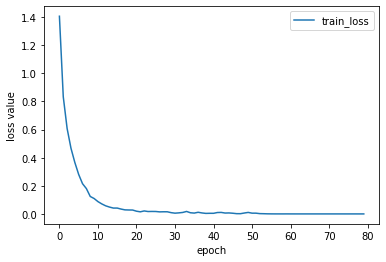

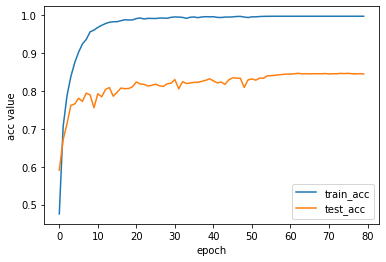

In [1]:
import matplotlib.pyplot as plt
loss_epochs = [1.40666156186133, 0.8332906006550302, 0.6077227543811409, 0.46742488687135736, 0.3662230696301071, 0.2807674648202195, 0.21493795042743488, 0.18018387254251508, 0.12424715353670168, 0.10963830125651189, 0.08758355987885473, 0.07112528568095698, 0.05765486833145272, 0.0486488381486234, 0.041610374904180666, 0.04163345575275622, 0.03453756588967327, 0.028865786232481882, 0.027978513557321335, 0.027612552217835068, 0.019376123229597638, 0.014959357600488072, 0.02117907021750639, 0.017067622090749232, 0.017571368521555775, 0.01727375387551491, 0.01456742866169091, 0.015270360937337297, 0.015184479813704419, 0.008995889034033136, 0.005365769404974975, 0.007481309945061946, 0.010428300180397596, 0.017583923103413734, 0.008311317235615096, 0.005993896966434217, 0.01166478907792652, 0.0069481559355840635, 0.003756215730687955, 0.004417144415574326, 0.0043402038374960265, 0.009909936653067624, 0.01066403331075277, 0.006201789843729859, 0.006965797948080818, 0.004855991107303582, 0.00183860988413564, 0.001685429612354376, 0.006449987368072545, 0.010651396576799832, 0.005359693206405702, 0.005371081198935993, 0.0021225553164742673, 0.001490768519200786, 0.000625242341579813, 0.0003177018182780056, 0.0001291844596102126, 9.67617713392744e-05, 5.848990404928725e-05, 0.00018433994697790362, 5.345083088184542e-05, 3.591698929753597e-05, 2.8578914740434383e-05, 2.762491753020761e-05, 2.2912988175467408e-05, 2.068913884228578e-05, 1.693329232747304e-05, 1.72367768785228e-05, 1.6899131100337992e-05, 1.6127760173332013e-05, 1.355213690050398e-05, 1.363351558856433e-05, 1.5986685262268278e-05, 1.3789292061536966e-05, 1.0765350600765989e-05, 1.1069157386716644e-05, 1.2775606604946563e-05, 1.1674208234562313e-05, 1.0292720055670599e-05, 9.776257506789024e-06]
train_acc_epochs = [0.47544642857142855, 0.7059550382653061, 0.7869300063775511, 0.8374123086734694, 0.8739237882653061, 0.9015066964285714, 0.9233697385204082, 0.9354671556122449, 0.955436862244898, 0.9600406568877551, 0.9670360331632653, 0.9725366709183674, 0.977180325255102, 0.9805484693877551, 0.9820033482142857, 0.9822026466836735, 0.9847138073979592, 0.9872648278061225, 0.9865872130102041, 0.9869260204081632, 0.9903340242346939, 0.9918885522959183, 0.9892777423469388, 0.9909119897959183, 0.9907525510204082, 0.9905133928571429, 0.9916294642857143, 0.9916892538265306, 0.9912109375, 0.9936025191326531, 0.9946787308673469, 0.9942004145408163, 0.9934630102040817, 0.9908721301020408, 0.9939213966836735, 0.9944794323979592, 0.9927654655612245, 0.9945790816326531, 0.9953164859693877, 0.9950175382653061, 0.9952566964285714, 0.9934829400510204, 0.9931640625, 0.9943797831632653, 0.9942602040816326, 0.9947983099489796, 0.9958346619897959, 0.9960738201530612, 0.9944595025510204, 0.9930843431122449, 0.9949178890306123, 0.9949577487244898, 0.9957549426020408, 0.99609375, 0.9963129783163265, 0.9964126275510204, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964325573979592, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755, 0.9964923469387755]
test_acc_epochs = [0.59091796875, 0.67099609375, 0.7130859375, 0.7615234375, 0.76513671875, 0.78037109375, 0.7720703125, 0.79375, 0.7890625, 0.7552734375, 0.7921875, 0.78408203125, 0.8033203125, 0.80859375, 0.78564453125, 0.79609375, 0.8072265625, 0.80556640625, 0.80595703125, 0.81064453125, 0.8232421875, 0.81796875, 0.81689453125, 0.8125, 0.814453125, 0.817578125, 0.81318359375, 0.8115234375, 0.818359375, 0.819921875, 0.82958984375, 0.805078125, 0.82412109375, 0.819140625, 0.82060546875, 0.8224609375, 0.822265625, 0.825, 0.8275390625, 0.831640625, 0.826171875, 0.82080078125, 0.82294921875, 0.8171875, 0.82880859375, 0.834375, 0.833203125, 0.83310546875, 0.8087890625, 0.82880859375, 0.83125, 0.82802734375, 0.8333984375, 0.83310546875, 0.8396484375, 0.83974609375, 0.8408203125, 0.84208984375, 0.8431640625, 0.84404296875, 0.84384765625, 0.84482421875, 0.84609375, 0.84453125, 0.84501953125, 0.84462890625, 0.84501953125, 0.844921875, 0.84482421875, 0.84541015625, 0.8443359375, 0.844921875, 0.8447265625, 0.8458984375, 0.8453125, 0.84599609375, 0.84482421875, 0.84462890625, 0.8451171875, 0.8443359375]
plt.plot(loss_epochs, label='train_loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()

plt.plot(train_acc_epochs, label='train_acc')
plt.plot(test_acc_epochs, label='test_acc')
plt.xlabel('epoch')
plt.ylabel('acc value')
plt.legend()
plt.show()
